# Learning the conditional prior over classes for image diffusion

**Author: Christopher Beckham**

Code builds upon the [original annotated diffusion code](https://huggingface.co/blog/annotated-diffusion), and inherits whatever license that code has.

If there are any bugs in the code, questions, or concerns, please reach out to me either on [Twitter](https://twitter.com/chris_j_beckham), Github (make an issue), or email me at christopher.j.beckham(at)gmail(dot)com. Thanks.

## Preliminaries

In [29]:
import math
from inspect import isfunction
from functools import partial
import os

%matplotlib inline
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

import torch
from torch import nn, einsum
import torch.nn.functional as F

import numpy as np

from copy import deepcopy

In [2]:
%pip install einops

Note: you may need to restart the kernel to use updated packages.


In [3]:
from einops import rearrange

In [4]:
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader

In [5]:
from torch.optim import Adam
device = "cuda" if torch.cuda.is_available() else "cpu"

----------

## Dataset

In [8]:
from torchvision.datasets import MNIST
ds = MNIST(
    "/tmp", 
    download=True, 
    transform=transforms.Compose(
        [transforms.Resize(32), 
         transforms.ToTensor(),
         transforms.Normalize((0.5,), (0.5,))]
    )
)

In [9]:
loader = DataLoader(ds, batch_size=32, shuffle=True)

---------

## Network code /  helpers

In [10]:
def exists(x):
    return x is not None

def default(val, d):
    if exists(val):
        return val
    return d() if isfunction(d) else d

class Residual(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    def forward(self, x, *args, **kwargs):
        return self.fn(x, *args, **kwargs) + x

def Upsample(dim):
    return nn.ConvTranspose2d(dim, dim, 4, 2, 1)

def Downsample(dim):
    return nn.Conv2d(dim, dim, 4, 2, 1)


In [11]:
class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings

In [12]:
class Block(nn.Module):
    def __init__(self, dim, dim_out, groups = 8):
        super().__init__()
        self.proj = nn.Conv2d(dim, dim_out, 3, padding = 1)
        self.norm = nn.GroupNorm(groups, dim_out)
        self.act = nn.SiLU()

    def forward(self, x, scale_shift = None):
        x = self.proj(x)
        x = self.norm(x)

        if exists(scale_shift):
            scale, shift = scale_shift
            x = x * (scale + 1) + shift

        x = self.act(x)
        return x

class ResnetBlock(nn.Module):
    """https://arxiv.org/abs/1512.03385"""
    
    def __init__(self, dim, dim_out, *, time_emb_dim=None, groups=8):
        super().__init__()
        self.mlp = (
            nn.Sequential(nn.SiLU(), nn.Linear(time_emb_dim, dim_out))
            if exists(time_emb_dim)
            else None
        )

        self.block1 = Block(dim, dim_out, groups=groups)
        self.block2 = Block(dim_out, dim_out, groups=groups)
        self.res_conv = nn.Conv2d(dim, dim_out, 1) if dim != dim_out else nn.Identity()

    def forward(self, x, time_emb=None):
        h = self.block1(x)

        if exists(self.mlp) and exists(time_emb):
            time_emb = self.mlp(time_emb)
            h = rearrange(time_emb, "b c -> b c 1 1") + h

        h = self.block2(h)
        return h + self.res_conv(x)
    
class ConvNextBlock(nn.Module):
    """https://arxiv.org/abs/2201.03545"""

    def __init__(self, dim, dim_out, *, n_classes=None, time_emb_dim=None, mult=2, norm=True):
        super().__init__()
        self.mlp = (
            nn.Sequential(nn.GELU(), nn.Linear(time_emb_dim, dim))
            if exists(time_emb_dim)
            else None
        )
        
        #self.embed = (
        #    nn.Sequential(nn.Embedding(n_classes, dim))
        #    if exists(n_classes)
        #    else None
        #)

        self.ds_conv = nn.Conv2d(dim, dim, 7, padding=3, groups=dim)

        self.net = nn.Sequential(
            nn.GroupNorm(1, dim) if norm else nn.Identity(),
            nn.Conv2d(dim, dim_out * mult, 3, padding=1),
            nn.GELU(),
            nn.GroupNorm(1, dim_out * mult),
            nn.Conv2d(dim_out * mult, dim_out, 3, padding=1),
        )

        self.res_conv = nn.Conv2d(dim, dim_out, 1) if dim != dim_out else nn.Identity()

    def forward(self, x, time_emb=None):
        h = self.ds_conv(x)
        
        # scale + Shift??
        
        #if exists(self.embed) and exists(y):
        #    assert exists(y), "y embedding must be passed in"
        #    y_condition = self.embed(y)
        #    h = h * rearrange(y_condition, "b c -> b c 1 1")

        if exists(self.mlp) and exists(time_emb):
            assert exists(time_emb), "time embedding must be passed in"
            condition = self.mlp(time_emb)
            h = h + rearrange(condition, "b c -> b c 1 1")

        h = self.net(h)
        return h + self.res_conv(x)


In [13]:
class Attention(nn.Module):
    def __init__(self, dim, heads=4, dim_head=32):
        super().__init__()
        self.scale = dim_head**-0.5
        self.heads = heads
        hidden_dim = dim_head * heads
        self.to_qkv = nn.Conv2d(dim, hidden_dim * 3, 1, bias=False)
        self.to_out = nn.Conv2d(hidden_dim, dim, 1)

    def forward(self, x):
        b, c, h, w = x.shape
        qkv = self.to_qkv(x).chunk(3, dim=1)
        q, k, v = map(
            lambda t: rearrange(t, "b (h c) x y -> b h c (x y)", h=self.heads), qkv
        )
        q = q * self.scale

        sim = einsum("b h d i, b h d j -> b h i j", q, k)
        sim = sim - sim.amax(dim=-1, keepdim=True).detach()
        attn = sim.softmax(dim=-1)

        out = einsum("b h i j, b h d j -> b h i d", attn, v)
        out = rearrange(out, "b h (x y) d -> b (h d) x y", x=h, y=w)
        return self.to_out(out)

class LinearAttention(nn.Module):
    def __init__(self, dim, heads=4, dim_head=32):
        super().__init__()
        self.scale = dim_head**-0.5
        self.heads = heads
        hidden_dim = dim_head * heads
        self.to_qkv = nn.Conv2d(dim, hidden_dim * 3, 1, bias=False)

        self.to_out = nn.Sequential(nn.Conv2d(hidden_dim, dim, 1), 
                                    nn.GroupNorm(1, dim))

    def forward(self, x):
        b, c, h, w = x.shape
        qkv = self.to_qkv(x).chunk(3, dim=1)
        q, k, v = map(
            lambda t: rearrange(t, "b (h c) x y -> b h c (x y)", h=self.heads), qkv
        )

        q = q.softmax(dim=-2)
        k = k.softmax(dim=-1)

        q = q * self.scale
        context = torch.einsum("b h d n, b h e n -> b h d e", k, v)

        out = torch.einsum("b h d e, b h d n -> b h e n", context, q)
        out = rearrange(out, "b h c (x y) -> b (h c) x y", h=self.heads, x=h, y=w)
        return self.to_out(out)


In [14]:
class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.fn = fn
        self.norm = nn.GroupNorm(1, dim)

    def forward(self, x):
        x = self.norm(x)
        return self.fn(x)

In [15]:
class Rearrange(nn.Module):
    def __init__(self, new_dim):
        super().__init__()
        self.new_dim = new_dim
    def forward(self, x):
        return x.reshape((-1, *self.new_dim))

In [16]:
class Unet(nn.Module):
    def __init__(
        self,
        dim,
        n_classes,
        y_max_norm=1.0,
        init_dim=None,
        out_dim=None,
        dim_mults=(1, 2, 4, 8),
        channels=3,
        with_time_emb=True,
        resnet_block_groups=8,
        use_convnext=True,
        convnext_mult=2,
    ):
        super().__init__()

        # determine dimensions
        self.channels = channels

        init_dim = default(init_dim, dim // 3 * 2)
        self.init_conv = nn.Conv2d(channels*2, init_dim, 7, padding=3)

        dims = [init_dim, *map(lambda m: dim * m, dim_mults)]
        in_out = list(zip(dims[:-1], dims[1:]))
        
        if use_convnext:
            block_klass = partial(ConvNextBlock, mult=convnext_mult)
        else:
            block_klass = partial(ResnetBlock, groups=resnet_block_groups)
            
        self.yy = nn.Sequential(
            nn.Embedding(n_classes, channels*32*32, max_norm=y_max_norm),
            Rearrange( (1, 32, 32) )
        )

        # time embeddings
        if with_time_emb:
            time_dim = dim * 4
            self.time_mlp = nn.Sequential(
                SinusoidalPositionEmbeddings(dim),
                nn.Linear(dim, time_dim),
                nn.GELU(),
                nn.Linear(time_dim, time_dim),
            )
        else:
            time_dim = None
            self.time_mlp = None

        # layers
        self.downs = nn.ModuleList([])
        self.ups = nn.ModuleList([])
        num_resolutions = len(in_out)

        for ind, (dim_in, dim_out) in enumerate(in_out):
            is_last = ind >= (num_resolutions - 1)

            self.downs.append(
                nn.ModuleList(
                    [
                        block_klass(dim_in, dim_out, 
                                    n_classes=n_classes, time_emb_dim=time_dim),
                        block_klass(dim_out, dim_out, 
                                    n_classes=n_classes, time_emb_dim=time_dim),
                        Residual(PreNorm(dim_out, LinearAttention(dim_out))),
                        Downsample(dim_out) if not is_last else nn.Identity(),
                    ]
                )
            )

        mid_dim = dims[-1]
        self.mid_block1 = block_klass(mid_dim, mid_dim, 
                                      n_classes=n_classes, time_emb_dim=time_dim)
        self.mid_attn = Residual(PreNorm(mid_dim, Attention(mid_dim)))
        self.mid_block2 = block_klass(mid_dim, mid_dim, 
                                      n_classes=n_classes, time_emb_dim=time_dim)

        for ind, (dim_in, dim_out) in enumerate(reversed(in_out[1:])):
            is_last = ind >= (num_resolutions - 1)

            self.ups.append(
                nn.ModuleList(
                    [
                        block_klass(dim_out * 2, dim_in, 
                                    n_classes=n_classes, time_emb_dim=time_dim),
                        block_klass(dim_in, dim_in, 
                                    n_classes=n_classes, time_emb_dim=time_dim),
                        Residual(PreNorm(dim_in, LinearAttention(dim_in))),
                        Upsample(dim_in) if not is_last else nn.Identity(),
                    ]
                )
            )

        out_dim = default(out_dim, channels)
        self.final_conv = nn.Sequential(
            block_klass(dim, dim), nn.Conv2d(dim, out_dim, 1)
        )

    def forward(self, x, y, time):
        
        #yy = self.yy(y)
        x = self.init_conv(torch.cat((x,y),dim=1))

        t = self.time_mlp(time) if exists(self.time_mlp) else None

        h = []
    
        # downsample
        for block1, block2, attn, downsample in self.downs:
            x = block1(x, t)
            x = block2(x, t)
            x = attn(x)
            h.append(x)
            x = downsample(x)

        # bottleneck
        x = self.mid_block1(x, t)
        x = self.mid_attn(x)
        x = self.mid_block2(x, t)

        # upsample
        for block1, block2, attn, upsample in self.ups:
            x = torch.cat((x, h.pop()), dim=1)
            x = block1(x, t)
            x = block2(x, t)
            x = attn(x)
            x = upsample(x)

        return self.final_conv(x)


In [17]:
def extract(a, t, x_shape):
    batch_size = t.shape[0]
    out = a.gather(-1, t.cpu())
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)

### Schedules for beta

In [18]:
def cosine_beta_schedule(timesteps, s=0.008):
    """
    cosine schedule as proposed in https://arxiv.org/abs/2102.09672
    """
    steps = timesteps + 1
    x = torch.linspace(0, timesteps, steps)
    alphas_cumprod = torch.cos(((x / timesteps) + s) / (1 + s) * torch.pi * 0.5) ** 2
    alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
    betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
    return torch.clip(betas, 0.0001, 0.9999)

def linear_beta_schedule(timesteps, beta_start=0.0001, beta_end=0.02):
    return torch.linspace(beta_start, beta_end, timesteps)

def quadratic_beta_schedule(timesteps,     beta_start = 0.0001,     beta_end = 0.02, exponent=2):
    return torch.linspace(beta_start**0.5, beta_end**0.5, timesteps) ** exponent

def sigmoid_beta_schedule(timesteps, beta_start = 0.0001,     beta_end = 0.02):
    betas = torch.linspace(-6, 6, timesteps)
    return torch.sigmoid(betas) * (beta_end - beta_start) + beta_start

### Conditional diffusion class

In [66]:
class ConditionalDiffusion:
    
    def __init__(self, model, betas, m):
        assert len(betas) == len(m)
       
        self.model = model
        self.betas = betas
        self.m = m
        
        self.alphas = 1. - self.betas
        self.alphas_cumprod = torch.cumprod(self.alphas, axis=0)
        self.sqrt_alphas_cumprod = torch.sqrt(self.alphas_cumprod)
        self.sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - self.alphas_cumprod)
        
        self.one_minus_alphas_cumprod = 1. - self.alphas_cumprod
        self.deltas = self.one_minus_alphas_cumprod - (self.m**2)*self.alphas_cumprod
        
        # -----
        self.deltas_prev = F.pad(self.deltas[:-1], (1, 0), value=0.0)
        self.m_prev = F.pad(self.m[:-1], (1, 0), value=0.0)
        
        self.delta_given_prev = self.deltas - \
            ( ((1-self.m) / (1-self.m_prev))**2 * self.alphas * self.deltas_prev)

        self.best_weights = None
        self.best_metric = np.inf

    # don't nograd this cos we learn y
    def sample_prior(self, ybatch):
        
        bs = ybatch.size(0)
        T_minus1 = torch.full((bs,), timesteps-1, device=device, dtype=torch.long)
        
        # compute variance
        delta_T = extract(self.deltas, T_minus1, ybatch.shape)
        
        # compute mu
        sqrt_alphas_cumprod_T = extract(self.sqrt_alphas_cumprod, T_minus1, ybatch.shape)
        this_mu = sqrt_alphas_cumprod_T*ybatch*self.m[-1]
        
        noise = torch.randn_like(ybatch).to(ybatch.device)
        return noise*delta_T + this_mu
    
    @torch.no_grad()
    def q_sample(self, x0, y, t, noise):
        sqrt_alphas_cumprod_t = extract(self.sqrt_alphas_cumprod, t, x0.shape)
        m_t = extract(self.m, t, x0.shape)
        term1 = ((1. - m_t)*sqrt_alphas_cumprod_t*x0 + m_t*sqrt_alphas_cumprod_t*y)
        sqrt_delta_t = extract(torch.sqrt(self.deltas), t, x0.shape)
        term2 = sqrt_delta_t*noise
        x_t = term1 + term2
        return x_t
    
    @torch.no_grad()
    def p_sample(self, x, y, t, t_index):

        m_t = extract(self.m, t, x.shape)
        m_tminus1 = extract(self.m_prev, t, x.shape)
        delta_t = extract(self.deltas, t, x.shape)
        delta_tminus1 = extract(self.deltas_prev, t, x.shape)
        sqrt_alpha_t = extract(torch.sqrt(self.alphas), t, x.shape)
        alpha_t = extract(self.alphas, t, x.shape)
        delta_given_prev_t = extract(self.delta_given_prev, t, x.shape)
        #delta_t_given_tminus1 = delta_t - ( ( (1-m_t) / (1-m_tminus1) )**2 * alpha_t * delta_tminus1 )

        c_xt_term1 = ((1 - m_t) / (1 - m_tminus1)) * (delta_tminus1 / delta_t) * sqrt_alpha_t
        c_xt_term2 = (1 - m_tminus1) * (delta_given_prev_t / delta_t) * (1. / sqrt_alpha_t)
        c_xt = c_xt_term1 + c_xt_term2

        c_yt_term1 = (m_tminus1*delta_t - ( (m_t * (1-m_t)) / (1-m_tminus1) ) * alpha_t*delta_tminus1)
        sqrt_alphas_cumprod_tminus1 = extract(self.sqrt_alphas_cumprod, t-1, x.shape)
        c_yt_term2 = sqrt_alphas_cumprod_tminus1 / delta_t
        c_yt = c_yt_term1 * c_yt_term2

        c_et_term1 = (1 - m_tminus1) * (delta_given_prev_t / delta_t)
        sqrt_one_minus_alphas_cumprod_t = extract(
            self.sqrt_one_minus_alphas_cumprod,
            t, x.shape
        )
        c_et_term2 = sqrt_one_minus_alphas_cumprod_t / sqrt_alpha_t
        c_et = c_et_term1 * c_et_term2

        pred_eps = self.model(x, y, t)

        posterior_mean = c_xt*x + c_yt*y - c_et*pred_eps
        tilde_delta_t = (delta_given_prev_t * delta_t) / delta_tminus1
        posterior_sd = tilde_delta_t

        if t_index == 1:
            # This is somewhat awkward: since the reverse process uses some variables
            # that index into t-1, we can't go down to t=0 since we'd be indexing negatively 
            # (i.e. 0-1 = -1). Perhaps one could define mathematically a "t_{-1}"? Anyway,
            # if T is large enough when we can simply say that t_0 \approx t_1.
            return posterior_mean

        noise = torch.randn_like(x)
        return noise*posterior_sd + posterior_mean  
    
    @torch.no_grad()
    def p_sample_loop(self, ybatch_, custom_y_batch=None):
        device = next(self.model.parameters()).device
        
        if custom_y_batch is None:
            ybatch = self.model.yy(ybatch_)
        else:
            ybatch = custom_y_batch
            
        print(type(ybatch))

        #b = shape[0]
        b = len(ybatch)
        img = self.sample_prior(ybatch)
        imgs = []
        
        for i in tqdm(reversed(range(1, timesteps)), 
                      desc='sampling loop time step', 
                      total=timesteps):
            img = self.p_sample( 
                img, 
                ybatch,
                torch.full((b,), i, device=device, dtype=torch.long),
                i
            )
            imgs.append(img.cpu().numpy())
        return imgs
    
    def interpolate_noise(self, x0, y, t, noise):
        sqrt_one_minus_alphas_cumprod_t = extract(
            self.sqrt_one_minus_alphas_cumprod,
            t,
            x0.shape
        )
        m_t = extract(self.m, t, x0.shape)
        sqrt_alphas_cumprod_t = extract(self.sqrt_alphas_cumprod, t, x0.shape)
        sqrt_delta_t = extract(torch.sqrt(self.deltas), t, x0.shape)
        return (1. / sqrt_one_minus_alphas_cumprod_t) * \
            (m_t*sqrt_alphas_cumprod_t*(y-x0) + sqrt_delta_t*noise)
    
    def train(self, loader, num_epochs):
        if not hasattr(self.model, 'yy'):
            raise NotImplementedError("model should have an embedding layer called 'yy'")
        optimizer = Adam(self.model.parameters(), lr=1e-3)
        metrics = {'loss': []}
        for epoch in range(num_epochs):
            losses = []
            pbar = tqdm(total=len(loader))
            for b, (xbatch, ybatch_) in enumerate(loader):
                optimizer.zero_grad()
                xbatch = xbatch.to(device)
                ybatch_ = ybatch_.to(device)

                ybatch = self.model.yy(ybatch_)

                bs = xbatch.size(0)
                # Algorithm 1 line 3: sample t uniformally for every example in the batch
                t = torch.randint(0, timesteps, (bs,), device=device).long()
                #loss = p_losses(model, batch, t, loss_type="huber")
                noise = torch.randn_like(xbatch)
                x_t = self.q_sample(x0=xbatch, y=ybatch, t=t, noise=noise)
                predicted_noise = model(x_t, ybatch, t)
                interpolated_noise = self.interpolate_noise(xbatch, ybatch, t=t, noise=noise)
                loss = F.smooth_l1_loss(interpolated_noise, predicted_noise)
                loss.backward()
                optimizer.step()
                losses.append(loss.item())
                pbar.update(1)
                if b % 100 == 0:
                    pbar.set_description_str("{:.4f}".format(losses[-1]))
            pbar.close()
            avg_loss = np.mean(losses)
            metrics['loss'] = avg_loss
            if avg_loss < self.best_metric:
                self.best_metric = avg_loss
                self.best_weights = deepcopy(self.model.state_dict())
    def load_best_weights(self):
        self.model.load_state_dict(self.best_weights)

---------

## Training code

In [1]:
#torch.save(model.state_dict(), "tmp-best-weights.pkl")

In [31]:
# define beta schedule
timesteps = 200
n_samples = 10
num_epochs = 10
betas = linear_beta_schedule(timesteps) # beta_start=1e-4, beta_end=0.0095)

#for M_max in [0.3, 0.5, 0.7, 0.8, 0.9, 1.0]:
for M_max in [0.7]:
    print("running: {}".format(M_max))
    m = linear_beta_schedule(timesteps, 0, M_max)
    model = Unet(
        dim=32,
        n_classes=10,
        y_max_norm=1.0,
        channels=1,
        dim_mults=(1, 2, 4, 8)
    )
    model = model.to(device)
    cdiff = ConditionalDiffusion(model, betas, m)
    
    cdiff.train(loader, num_epochs=num_epochs)
    #cdiff.load_best_weights()
    
    #model.load_state_dict(torch.load("tmp-best-weights.pkl"))
    
    """
    ybatch_ = iter(loader).next()[1]
    ybatch_ = ybatch_.to(device)
    for iter_ in range(n_samples):
        samples = cdiff.p_sample_loop(ybatch_)[-1]
        plt.figure(figsize=(5,5))
        for j in range(5*5):
            plt.subplot(5,5,j+1)
            plt.imshow(samples[j][0], cmap='gray')
            plt.axis('off')
        out_dir = "figures_cdiff/{}-new".format(M_max)
        if not os.path.exists(out_dir):
            os.makedirs(out_dir)
        plt.savefig("{}/{}.png".format(out_dir, iter_))    
        plt.close()
    """

running: 0.7


Before evaluating, make sure you load the best weights (as determined by the lowest loss) by calling `model.load_best_weights()`. Or, just load mine from disk.

In [201]:
#model.load_state_dict(torch.load("tmp-best-weights.pkl"))

<All keys matched successfully>

In [33]:
cdiff.load_best_weights()

## Plot various parameters

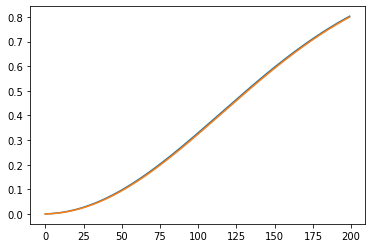

In [21]:
plt.plot(cdiff.deltas)
plt.plot(cdiff.deltas_prev)

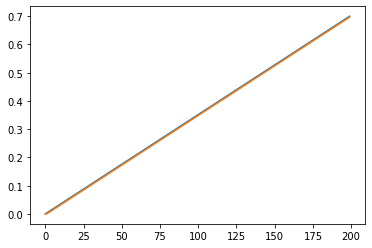

In [22]:
plt.plot(cdiff.m)
plt.plot(cdiff.m_prev)

This is the variance schedule of the unconditional formulation $p_{\theta}(x_{t-1}|x_t)$. I'm just plotting this so I can compare it later.

In [24]:
alphas_cumprod_prev = F.pad(cdiff.alphas_cumprod[:-1], (1, 0), value=1.0)
beta_tilde = (1-alphas_cumprod_prev) / (1-cdiff.alphas_cumprod) * cdiff.betas

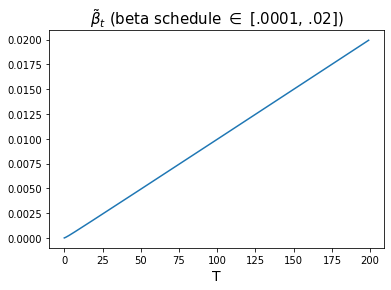

In [26]:
alphas_cumprod_prev = F.pad(cdiff.alphas_cumprod[:-1], (1, 0), value=1.0)
beta_tilde = (1-alphas_cumprod_prev) / (1-cdiff.alphas_cumprod) * cdiff.betas
plt.plot(beta_tilde)
plt.title("$\\tilde{\\beta}_t$ (beta schedule $\in$ [.0001, .02])", fontsize=15)
plt.xlabel('T', fontsize=14)
plt.savefig("figures_cdiff/beta_tilde.pdf", bbox_inches='tight')

m from 0 -> 0.2
m from 0 -> 0.375
m from 0 -> 0.55
m from 0 -> 0.7249999999999999
m from 0 -> 0.9


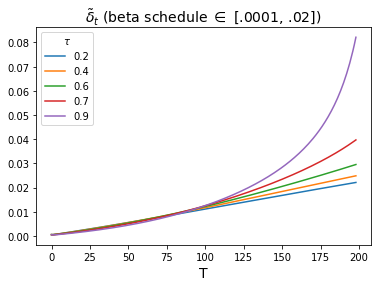

In [27]:
TEST_M = np.linspace(0.2,0.9,num=5)
betas = linear_beta_schedule(200)
for test_m in TEST_M:
    print("m from 0 -> {}".format(test_m))
    m = linear_beta_schedule(200, 0, test_m)
    cdiff = ConditionalDiffusion(None, betas, m)
    plt.plot(
        (cdiff.delta_given_prev * cdiff.deltas / cdiff.deltas_prev)[1:]
    )
plt.xlabel('T', fontsize=14)
plt.title("$\\tilde{\\delta}_t$ (beta schedule $\in$ [.0001, .02])", fontsize=14)
plt.legend([ "{:.1f}".format(test_m) for test_m in TEST_M], title="$\\tau$")
plt.savefig("figures_cdiff/delta_tilde.pdf", bbox_inches='tight')

In [28]:
#plt.plot(
#    (cdiff.delta_given_prev * cdiff.deltas / cdiff.deltas_prev)[1:]
#)
#plt.xlabel('T', fontsize=14)
#plt.title("$\\tilde{\\delta}_t$", fontsize=14)

-------

## Visualise forward diffusion

This is useful as we can qualitatively debug our variance schedule over the specified $T$ timesteps.

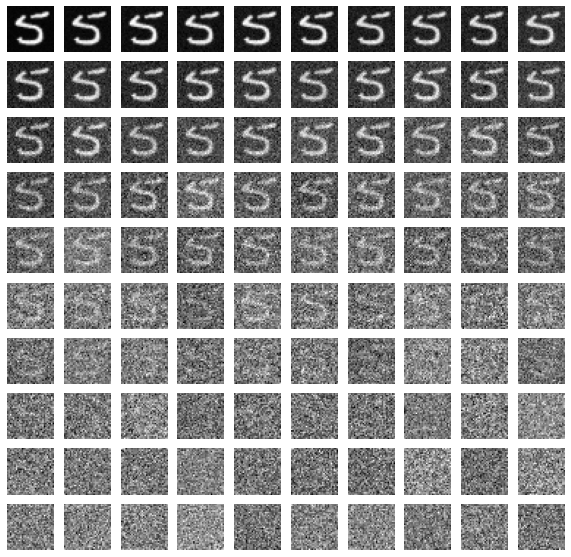

In [30]:
#ybatch = noise_fn(xbatch, unif_min=0.7)
xbatch, ybatch_ = iter(loader).next()
xbatch = xbatch.to(device)
ybatch_ = ybatch_.to(device)
ybatch = model.yy(ybatch_)[0:1].repeat(100, 1, 1, 1)
xbatch_repeat = xbatch[0:1].repeat(100, 1, 1, 1)
q_0T = cdiff.q_sample(
    xbatch_repeat, 
    y=ybatch,
    t=torch.linspace(1, timesteps-1, steps=100, device=xbatch_repeat.device).long(),
    noise=torch.randn_like(xbatch_repeat)
)
    
         
plt.figure(figsize=(10,10))
for j in range(10*10):
    plt.subplot(10,10,j+1)
    plt.imshow(q_0T.detach().cpu().numpy()[j][0], cmap='gray')
    plt.axis('off')
plt.savefig('figures_cdiff/forward.png', bbox_inches='tight')

In [34]:
all_idcs = torch.arange(0, 10).long().to(device)
all_yys = model.yy(all_idcs)

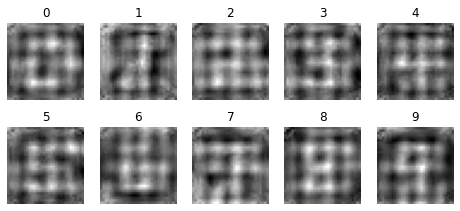

In [35]:
plt.figure(figsize=(8,3.5))
#plt.tight_layout()
for j in range(2*5):
    plt.subplot(2,5,j+1)
    plt.imshow(all_yys[j][0].detach().cpu().numpy(), cmap='gray')
    plt.axis('off')
    plt.title(j)
plt.savefig('figures_cdiff/yy.png', bbox_inches='tight')

## Sampling

In [36]:
# Now
ybatch_ = iter(loader).next()[1]
ybatch_ = ybatch_.to(device)
#samples1 = cdiff.p_sample_loop(ybatch_)[-1]
#samples2 = cdiff.p_sample_loop(ybatch_)[-1]

In [ ]:
samples=cdiff.p_sample_loop(ybatch_)
samples_end_np = samples[-1]
samples_start_np = samples[0]

In [ ]:
# another batch at full noise
plt.figure(figsize=(5,5))
for j in range(5*5):
    plt.subplot(5,5,j+1)
    plt.imshow(samples_end_np[j][0], cmap='gray')
    plt.axis('off')

### Messing with embeddings

I have modified `p_sample_loop` so that instead of giving labels `ybatch_` you can manually specify a `ybatch` directly. Let's generate some random interpolations from the `ybatch`'s that were learned by the model.

In [83]:
all_idcs_padded = all_idcs.view(-1, 1).repeat(1, 10)
all_idcs_padded = all_idcs_padded.view(-1)

In [84]:
all_yys_padded = model.yy(all_idcs_padded)

#### Convex combination between two labels

In [86]:
randperm = torch.randperm(all_yys_padded.size(0))
lamb_ = 0.5 # interp coefficient

yys_interp = lamb_*all_yys_padded + (1-lamb_)*all_yys_padded[randperm]
tmp_generated = cdiff.p_sample_loop(None, custom_y_batch=yys_interp)
#yys_all.shape

<class 'torch.Tensor'>


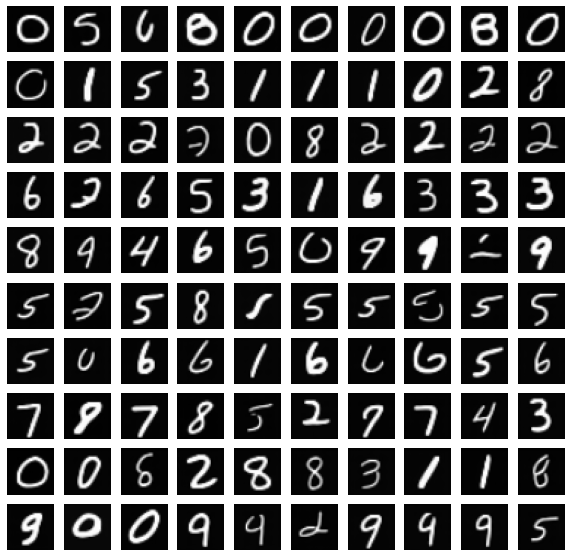

In [87]:
plt.figure(figsize=(10,10))
for j in range(10*10):
    plt.subplot(10,10,j+1)
    plt.imshow(tmp_generated[-1][j][0], cmap='gray')
    plt.axis('off')

#### Convex combination between a label and noise

In [93]:
yys_interp = 0.8*all_yys_padded + 0.2*torch.randn_like(all_yys_padded)
tmp_generated = cdiff.p_sample_loop(None, custom_y_batch=yys_interp)

<class 'torch.Tensor'>


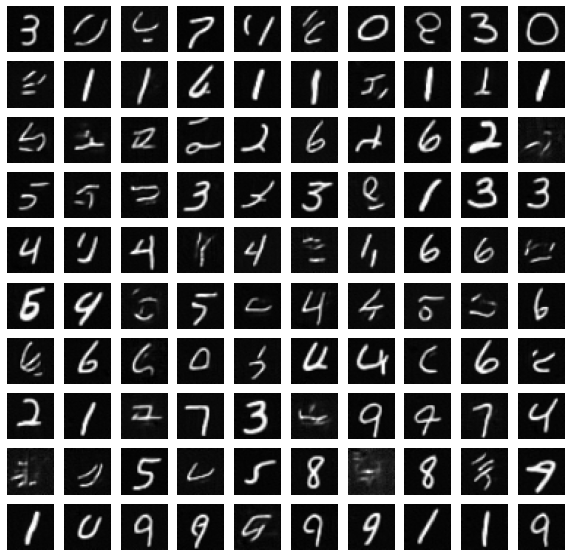

In [94]:
plt.figure(figsize=(10,10))
for j in range(10*10):
    plt.subplot(10,10,j+1)
    plt.imshow(tmp_generated[-1][j][0], cmap='gray')
    plt.axis('off')

### Generate frames for gif generation

In [158]:
%%bash
mkdir figures_cdiff/gif

In [160]:
samples_all = cdiff.p_sample_loop(all_idcs_padded)

for iter_ in range(len(samples_all)):
    plt.figure(figsize=(10,10))
    for j in range(10*10):
        plt.subplot(10,10,j+1)
        plt.imshow(samples_all[iter_][j][0], cmap='gray')
        plt.axis('off')
    plt.savefig('figures_cdiff/gif/%03d.png' % (iter_+1),
               bbox_inches='tight')
    plt.close()